# Inversions

In this notebook, we use a synthetic example to explore aspects of inversion including:
- assigning uncertainties to the the data
- adjusting the regularization parameters on the smallness and smoothness terms
- adjusting the value of the trade-off parameter beta

## Step 0: Imports and load survey info

These steps are the same as in the previous notebook. 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import matplotlib.gridspec as gridspec
import ipywidgets

# tools in the SimPEG Ecosystem 
import discretize  # for creating computational meshes

# SimPEG inversion machinery
from simpeg import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# solver 
from simpeg.utils.solver_utils import get_default_solver

# DC resistivity and IP modules
from simpeg.electromagnetics import resistivity as dc
from simpeg.electromagnetics.static.utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# our own data importer 
from my_utils import read_dcip_data

In [2]:
Solver = get_default_solver()

In [3]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 12

## Step 1: Load DC Survey

This is the same as in the previous notebook, but included so we can re-visit any of the steps as necessary. 

In [4]:
line = "46800E"

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

In [5]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=False)

In [6]:
# initialize an empty list for each 
source_list = []

# center the survey and work in local coordinates
x_local = 0.5*(np.min(dc_data_dict["a_locations"]) + np.max(np.hstack(dc_data_dict["n_locations"])))

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i] - x_local, 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i] - x_local,
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs, storeProjections=False)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i] - x_local, 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i] - x_local, 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [7]:
survey = dc.Survey(source_list=source_list)

## Step 2: Build a Mesh

Similar to the previous notebook, we use a simple function to design our mesh. 

In [8]:
def build_mesh(
    survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
):
    """
    A function for designing a Tensor Mesh based on DC survey parameters
    
    Parameters
    ----------
    
    survey: dc.Survey 
        A DC (or IP) survey object
    
    n_cells_per_spacing_[x, z]: int
        Number of [x, z]-cells per the minimum electrode spacing
        
    n_core_extra_[x, z]: int
        Number of extra cells with the same size as the core domain beyond the survey extent
    
    core_domain_z_ratio: float
        Factor that multiplies the maximum AB, MN separation to define the core mesh extent
    
    padding_factor: float
        Factor by which we expand the mesh cells in the padding region
    
    n_pad_[x, z]: int
        Number of padding cells in the x, z directions
    """
    min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))

    dx = min_electrode_spacing / n_cells_per_spacing_x
    dz = min_electrode_spacing / n_cells_per_spacing_z
    
    # define the x core domain
    core_domain_x = np.r_[
        survey.unique_electrode_locations[:, 0].min(),
        survey.unique_electrode_locations[:, 0].max()
    ]
    
    # find the y core domain
    # find the maximum spacing between source, receiver midpoints
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    separation_ab_mn = np.abs(mid_ab - mid_mn)
    max_separation = separation_ab_mn.max()
    core_domain_z = np.r_[-core_domain_z_ratio * max_separation, 0.]
    
    # add extra cells beyond the core domain
    n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra_x*2  # on each side
    n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra_z  # just below
    
    # define the tensors in each dimension
    hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
    hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

    mesh = discretize.TensorMesh([hx, hz], x0="CN")

    return mesh, core_domain_x, core_domain_z

<Axes: xlabel='x1', ylabel='x2'>

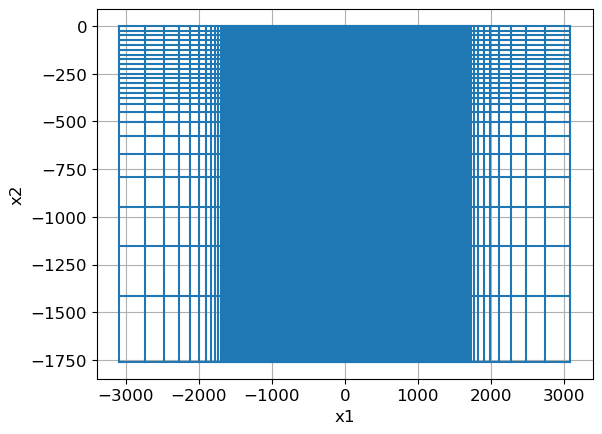

In [9]:
mesh, core_domain_x, core_domain_z = build_mesh(survey)
mesh.plot_grid()

## Step 3: Design our True Model 

Here, we will focus in on a synthetic example so we know the true solution. Again, we will use a model containing 2 blocks in a halfspace. 

### 3.1 Define the model geometry and physical properties

Here, we define a model with one conductive block and one resistive block in a halfspace. 

In [10]:
# define the resistivities
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

# define the geometry of each block
xlim_resistive_block = np.r_[-500, -250]
zlim_resistive_block = np.r_[-150, -75]

xlim_conductive_block = np.r_[250, 500]
zlim_conductive_block = np.r_[-150, -75]

In [11]:
rho = rho_background * np.ones(mesh.nC)

# resistive block
inds_resistive_block = (
    (mesh.gridCC[:, 0] >= xlim_resistive_block.min()) & (mesh.gridCC[:, 0] <= xlim_resistive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_resistive_block.min()) & (mesh.gridCC[:, 1] <= zlim_resistive_block.max())
)

rho[inds_resistive_block] = rho_resistive_block

# conductive block
inds_conductive_block = (
    (mesh.gridCC[:, 0] >= xlim_conductive_block.min()) & (mesh.gridCC[:, 0] <= xlim_conductive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_conductive_block.min()) & (mesh.gridCC[:, 1] <= zlim_conductive_block.max())
)

rho[inds_conductive_block] = rho_conductive_block

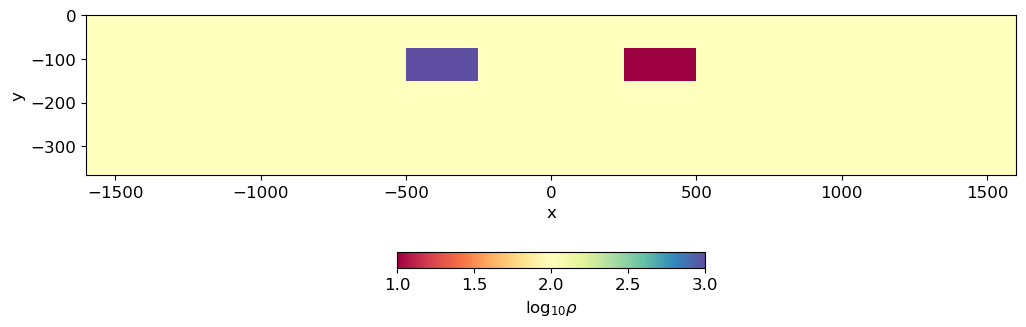

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
out = mesh.plot_image(np.log10(rho), ax=ax, pcolor_opts={"cmap":"Spectral"})
plt.colorbar(out[0], ax=ax, label="log$_{10} \\rho$", orientation="horizontal", fraction=0.05, pad=0.25)
ax.set_xlim(core_domain_x)
ax.set_ylim(core_domain_z + np.r_[-100, 0])
ax.set_aspect(1.5)

### 3.2 Define the true model

Since we will be working with log-resistivities in the inversion, our true model is defined as the log of the resistivity. 

In [13]:
model_true = np.log(rho)

## Step 4: Set up and run a forward simulation

These will be the "observed data" in the inversion. We add noise to the result (a default of 5%). If you would like to adjust the noise level, you can change the `relative_error`, you can pass `add_noise` to the `make_synthetic_data` function. 

As in the first notebook, we will invert for log-resistivity, so we use an `ExpMap` in the forward simulation. Again, we use the `storeJ` option to store the  

In [14]:
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey, storeJ=True
)

In [15]:
%%time 

# compute our "observed data"
synthetic_data = simulation_dc.make_synthetic_data(model_true, add_noise=True)

CPU times: user 715 ms, sys: 173 ms, total: 888 ms
Wall time: 289 ms


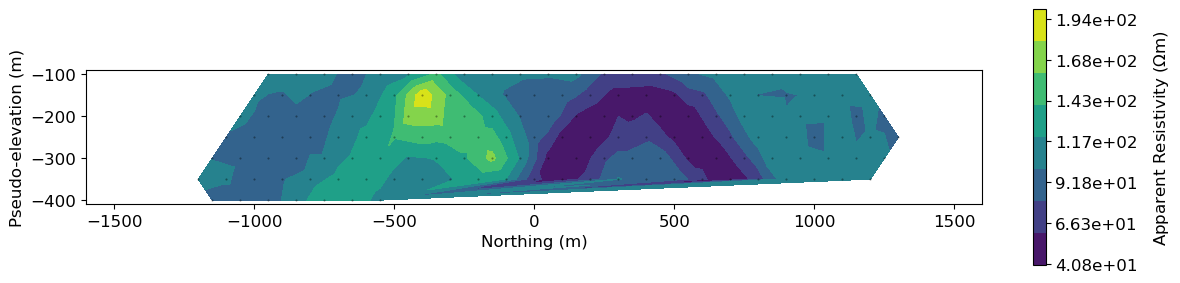

In [16]:
# plot pseudosections 
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
# plot a psuedosection of the data
rhoa_plot = apparent_resistivity_from_voltage(survey, synthetic_data.dobs)
plot_pseudosection(
    synthetic_data, dobs=rhoa_plot, 
    data_locations=True, ax=ax, 
    cbar_label="Apparent Resistivity ($\Omega$m)"
)
ax.set_xlim(core_domain_x)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_xlabel("Northing (m)")

plt.tight_layout()


---
# Recall: inversion as optimization 

We formulate the inverse problem as an optimization problem consisting of a data misfit and a regularization 

$$
\min_{\mathbf{m}} \Phi(\mathbf{m}) = \Phi_d(\mathbf{m}) + \beta\Phi_m(\mathbf{m}) \\ s.t. ~ \Phi_d \leq \Phi_d^* \quad \mathbf{m}_i^{\rm L} \leq \mathbf{m}_ \leq \mathbf{m}_i^{\rm U}
$$

where:
- $\mathbf{m}$ is our inversion model - a vector containing the set of parameters that we invert for


- $\Phi_d$ is the data misfit
  $$
  \Phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) -    \mathbf{d}^{\text{obs}})\|^2
  $$
  

- $\Phi_m$ is the regularization
  $$
  \Phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_x\|\mathbf{W_x} (\mathbf{m})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
  $$
  

- $\beta$ is a trade-off parameter that weights the relative importance of the data misfit and regularization terms


- $\Phi_d^*$ is our target misfit, which is typically set to $N/2$ where $N$ is the number of data (Parker, 1994) (or also see [Oldenburg & Li (2005)](https://www.researchgate.net/profile/Douglas_Oldenburg/publication/238708196_5_Inversion_for_Applied_Geophysics_A_Tutorial/links/004635282572529927000000.pdf))
---


## Step 5: assign standard deviations to the data

The standard deviations are an estimate of the level of noise on your data. These are used to construct the weights in the $\mathbf{W_d}$ matrix of the data misfit.

It is common to define the standard deviation in terms of a `relative_error` and a `noise_floor`. 

$$\rm{standard~deviation}  =  \rm{relative~error}\times|d^{obs}| + \rm{noise~floor}$$

For DC resistivity, it is common to choose a `relative_error` between 0.02-0.1 (2% - 10% error). The `noise_floor` value defines threshold for data below which we consider those values to be close to zero. It is important to set a non-zero `noise_floor` when we can have zero-crossings in our data (e.g. both positive and negative values - which we do in DC!). The `noise_floor` ensures that we don't try to fit near-zero values to very high accuracy.  

Text(0.5, 0, '$log_{10}(|d^{obs}|)$')

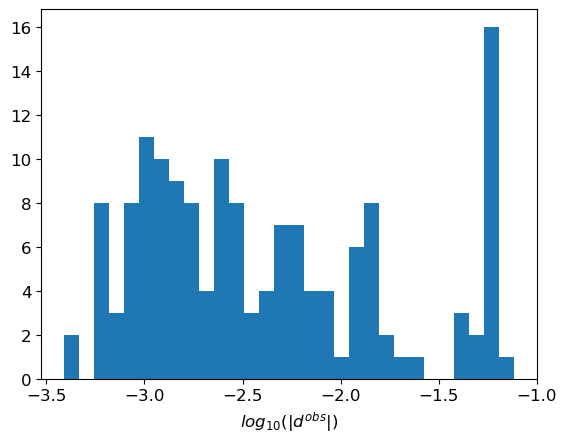

In [17]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(np.abs(synthetic_data.dobs)), 30)
ax.set_xlabel("$log_{10}(|d^{obs}|)$")

In [18]:
relative_error = 0.05  # 5% error
noise_floor = 1e-4

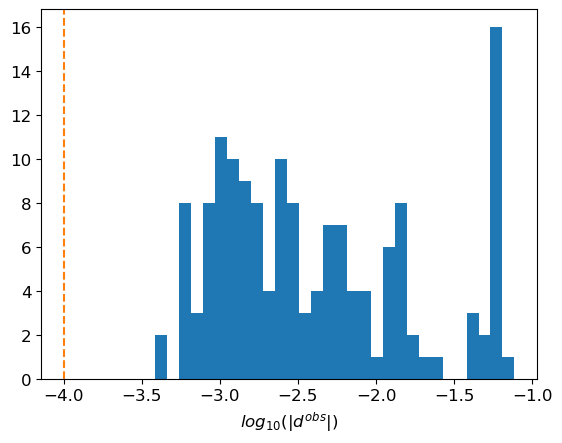

In [19]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(np.abs(synthetic_data.dobs)), 30)
ax.set_xlabel("$log_{10}(|d^{obs}|)$")
ax.axvline(np.log10(noise_floor), linestyle="dashed", color="C1")

### 5.1 Assign uncertainties to our data object

In SimPEG, the `data` object is responsible for keeping track of the survey geometry, observed data and uncertainty values. The `standard_deviation` property is what is used to construct the $\mathbf{W_d}$ matrix in the data misfit

```
W_d = diag(1 / data.standard_deviation) 
```

In [20]:
synthetic_data.relative_error = relative_error
synthetic_data.noise_floor = noise_floor

Plot the data sorted by amplitude and associated uncertainties.

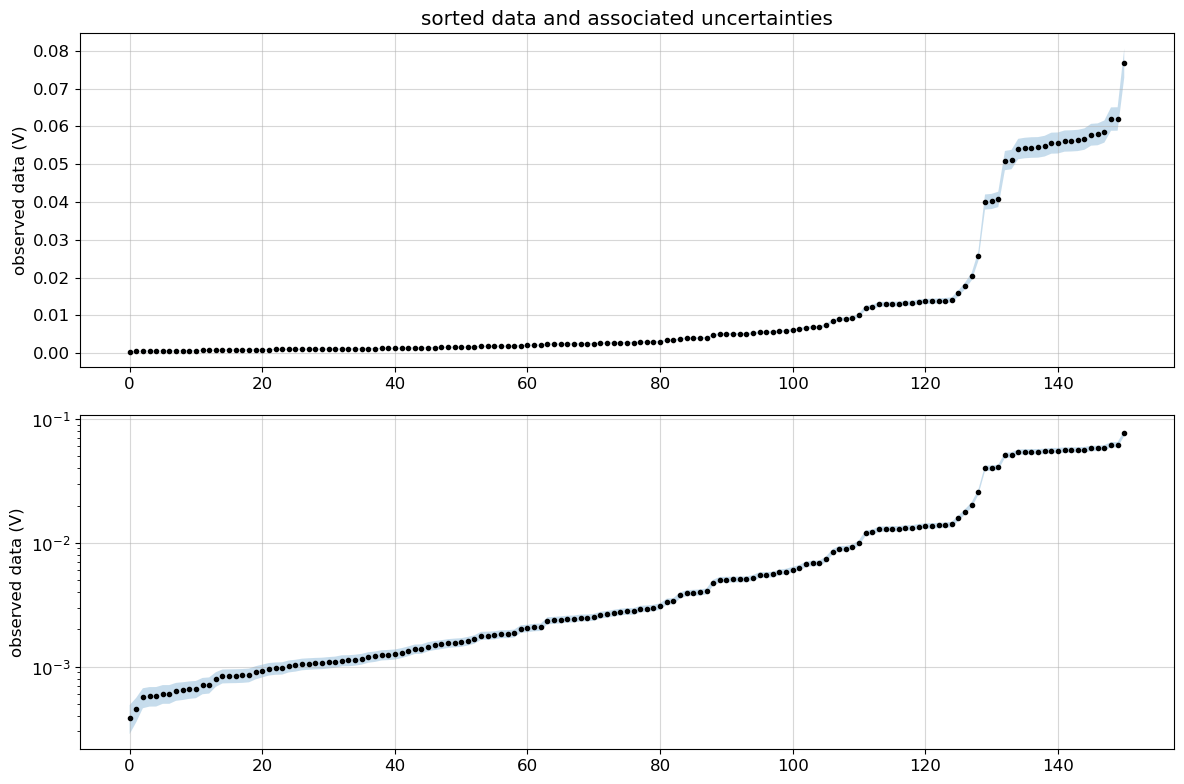

In [21]:
inds_sort = np.argsort(np.abs(synthetic_data.dobs))
sorted_data = np.abs(synthetic_data.dobs[inds_sort])
sorted_std = synthetic_data.standard_deviation[inds_sort]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

x = np.arange(0, len(sorted_data))

ax[0].plot(x, sorted_data, '.k')
ax[1].semilogy(x, sorted_data, '.k')

ax[0].set_title("sorted data and associated uncertainties")

for a in ax:
    a.fill_between(x, sorted_data - sorted_std, sorted_data + sorted_std, alpha=0.25)
    a.grid(alpha=0.5)
    a.set_ylabel("observed data (V)")

plt.tight_layout()

## Step 6: Assembling the inversion 

Here, we are going to set up functions for constructing and running the inversion so that we can easily adjust the parameters used in the inversion.

We start be defining a function that will construct our `inverse_problem` object which requires the `data_misfit`, `regularization`, and `optimization` be constructed. 

In [22]:
def create_inverse_problem(
    relative_error=relative_error, noise_floor=noise_floor,
    alpha_s=1e-3,  alpha_x=1, alpha_z=1, mref=np.log(rho_background), 
    maxIter=20, maxIterCG=20,
):
    """
    A function that contructs a data misfit, regularization, and optimization and 
    assembles them into an inverse_problem object. 
    
    Parameters
    ----------
    
    relative_error: float
        relative error we assign to the data (used to construct the standard_deviation)
    
    noise_floor: float
        noise floor that we use to construct the standard deviations of the data
    
    alpha_s: float
        weight for the smallness component of the regularization
    
    alpha_[x, z]: float
        weight for the [x, z]-smoothness term in the regularization
    
    mref: float
        reference model value used in the smallness term of the regularization
    
    maxIter: int
        maximum number of iterations in the inversion
    
    maxIterCG: int
        maximum number of Conjugate Gradient iterations used to compute a step 
        in the Inexact Gauss Newton optimization
        
    """
    
    # set the uncertainties and define the data misfit
    synthetic_data.relative_error = relative_error
    synthetic_data.noise_floor = noise_floor
    dmisfit = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation_dc)
    
    # regularization
    reg = regularization.WeightedLeastSquares(
        mesh, alpha_s=alpha_s, alpha_x=alpha_x, alpha_y=alpha_z, reference_model=mref*np.ones(mesh.nC)
    )
    
    # optimization 
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)
    opt.remember("xc")
    
    # return the inverse problem 
    return inverse_problem.BaseInvProblem(dmisfit, reg, opt)

Next, we define a simple function for assembling the inversion. There are very simiar functions in SimPEG already that write these outputs to a file (see for example `directives.SaveOutputEveryIteration`). In part, I show this here to give you a sense of how directives work in the inversion so if you are interested in writing your own, then you can use this as a template. 

The `initialize` method is called at the very beginning of the inversion. In the `BetaEstimate_ByEig`, which we used in notebook 1, this is where we initialze an estimate of beta.

The `endIter` method is called at the end of every iteration. For example in the `BetaSchedule` directive, this is where we update the value of beta. 

In this directive, we will create a simple dictionary that saves some outputs of interest during the inversion. 

In [23]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "beta":[],
            "phi_d":[],
            "phi_m":[],
            "phi_m_small":[],
            "phi_m_smooth_x":[],
            "phi_m_smooth_z":[],
            "dpred":[],
            "model":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["phi_m"].append(self.invProb.phi_m)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)
        
        # grab the components of the regularization and evaluate them here
        # the regularization has a list of objective functions  
        # objfcts = [smallness, smoothness_x, smoothness_z]
        # and the multipliers contain the alpha values
        # multipliers = [alpha_s, alpha_x, alpha_z]
        reg = self.reg.objfcts[0] 
        phi_s = reg.objfcts[0](self.invProb.model) * reg.multipliers[0]
        phi_x = reg.objfcts[1](self.invProb.model) * reg.multipliers[1]
        phi_z = reg.objfcts[2](self.invProb.model) * reg.multipliers[2]
        
        self.inversion_results["phi_m_small"].append(phi_s)
        self.inversion_results["phi_m_smooth_x"].append(phi_x)
        self.inversion_results["phi_m_smooth_z"].append(phi_z)

There are three directives that we use in this inversion 
- `BetaEstimate_ByEig`: sets an initial value for $\beta$ by estimating the largest eigenvalue of  $\Phi_d$ and of $\Phi_m$ and then taking their ratio. The value is then scaled by the `beta0_ratio` value, so for example if you wanted the regularization to be ~10 times more important than the data misfit, then we would set `beta0_ratio=10`


- `BetaSchedule`: this reduces the value of beta during the course of the inversion. Particularly for non-linear problems, it can be advantageous to start off by seeking a smooth model which fits the regularization and gradually decreasing the infulence of the regularization to increase the influence of the data. 


- `TargetMisfit`: this directive checks at the end of each iteration if we have reached the target misfit. If we have, the inversion terminates, it not, it continues. Optionally, a `chifact` can be set to stop the inversion when `phi_d <= chifact * phi_d_star`. By default (`chifact=1`)

In [24]:
def create_inversion(
    inv_prob, beta0_ratio=1e2, cool_beta=True,
    beta_cooling_factor=2, beta_cooling_rate=1,
    use_target=True, chi_factor=1, 
):
    """
    A method for creating a SimPEG inversion with directives for estimating and 
    updating beta as well as choosing a stopping criteria
    
    Parameters
    ----------
    
    inv_prob: inverse_problem
        An inverse problem object that describes the data misfit, regularization and optimization
    
    beta0_ratio: float
        a scalar that multiplies ratio of the estimated largest eigenvalue of phi_d and phi_m
    
    cool_beta: bool
        True: use a beta cooling schedule. False: use a fixed beta
    
    beta_cooling_factor: float
        reduce beta by a factor of 1/beta_cooling factor 
    
    beta_cooling_rate: int
        number of iterations we keep beta fixed for 
        (we cool beta by the cooling factor every `beta_cooling_rate` iterations) 
    
    chi_factor: float
        Stop the inversion when phi_d <= chifact * phi_d_star. By default (`chifact=1`)
        
    """
    
    # set up our directives
    beta_est = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = directives.TargetMisfit(chifact=chi_factor)
    save = SaveInversionProgress()
    
    directives_list = [beta_est, save]
    
    if use_target is True:
        directives_list.append(target)
    
    if cool_beta is True:
        beta_schedule = directives.BetaSchedule(coolingFactor=beta_cooling_factor, coolingRate=beta_cooling_rate)
        directives_list.append(beta_schedule)

    return inversion.BaseInversion(inv_prob, directiveList=directives_list), target, save

### 6.1 Create and run the inversion

In [25]:
rho0 = rho_background

In [26]:
inv_prob = create_inverse_problem(
    relative_error=0.05, noise_floor=1e-4,
    alpha_s=1e-3,  alpha_x=1, alpha_z=1, mref=np.log(rho0), 
    maxIter=20, maxIterCG=20,
)

inv, target_misfit, inversion_log = create_inversion(
    inv_prob, beta0_ratio=1e2, cool_beta=True,
    beta_cooling_factor=2, beta_cooling_rate=1,
    use_target=False, chi_factor=1 
)

phi_d_star = survey.nD / 2
target = target_misfit.chifact * phi_d_star

In [27]:
m0 = np.log(rho0) * np.ones(mesh.nC)
model_recovered = inv.run(m0)
inversion_results = inversion_log.inversion_results


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.47e+02  4.34e+03  5.97e-28  4.34e+03    1.29e+03      0              
   1  2.73e+02  3.10e+03  1.01e+00  3.38e+03    4.45e+02      0              
   2  1.37e+02  2.51e+03  2.64e+00  2.87e+03    3.72e+02      0   Skip BFGS  
   3  6.84e+01  1.88e+03  6.07e+00  2.29e+03    2.82e+02      0   Skip BFGS  
   4  3.42e+01  1.31e+03  1.21e+01  1.73e+03    2.02e+02      0   Skip BFGS  
   5  1.71e+01  8.70e+02  2.15e+01  1.24e+03    1.39e+02      0   Skip BFG

In [28]:
# inversion_results_app = ipywidgets.interact(
#     plot_results_at_iteration,
#     iteration = ipywidgets.IntSlider(min=0, max=inversion_results["iteration"][-1]-1, value=0)
# )
# inversion_results_app

### 6.2 analyze the results - data misfit

In [29]:
def plot_normalized_misfit(iteration=None, observed_data=synthetic_data, ax=None):
    """
    Plot the normalized data misfit
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if iteration is None:
        dpred = inversion_results["dpred"][-1]
    else:
        dpred = inversion_results["dpred"][iteration]
        
    normalized_misfit = (dpred - observed_data.dobs)/observed_data.standard_deviation
    out = plot_pseudosection(
        observed_data, dobs=normalized_misfit,
        data_locations=True, ax=ax,
        cbar_label="Normalized misfit"
    )

    ax.set_title("normalized misfit")
    ax.set_yticklabels([])
    ax.set_aspect(1.5)  # some vertical exxageration
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("n-spacing")

    return ax

<Axes: title={'center': 'normalized misfit'}, xlabel='Northing (m)', ylabel='n-spacing'>

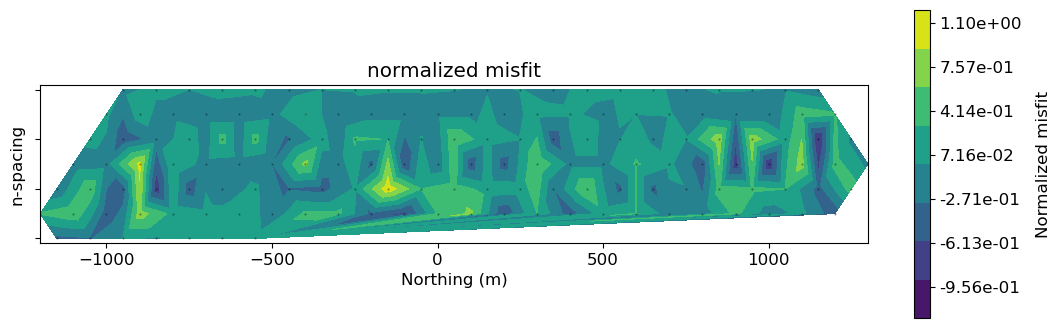

In [30]:
# plot misfit
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_normalized_misfit(ax=ax)

### 6.3 analyze the results - how did we get here? 

In [31]:
def plot_beta(inversion_results, x="iteration", ax=None):
    """
    Plot the beta-value as a function of iteration 
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if x not in ["iteration", "beta"]:
        raise Exception("beta should be plotted as a function of iteration or beta")
    ax.plot(inversion_results[x], inversion_results["beta"], "-oC0", label="$\\beta$")
    ax.set_ylabel("$\\beta$")
    ax.legend(loc=2)
    return ax

def plot_misfit_and_regularization(inversion_results, x="iteration", ax=None):
    """
    Plot the data misfit and regularization as a function of iteration
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    if x not in ["iteration", "beta"]:
        raise Exception("misfit and regularization should be plotted as a function of iteration or beta")
        
    ax.plot(inversion_results[x], inversion_results["phi_d"], "-oC1", label="$\Phi_d$")
    ax.axhline(phi_d_star, linestyle="--", color="k", label="$\Phi_d^*$")
    ax.axhline(phi_d_star, linestyle="-.", color="k", label="$\chi\Phi_d^*$")
    ax.set_ylabel("$\Phi_d$")

    ax_phim = ax.twinx()
    ax_phim.plot(inversion_results[x], inversion_results["phi_m"], "-oC2", label="$\Phi_m$")
    ax_phim.set_ylabel("$\Phi_m$")
    ax.set_xlabel(x)
    
    ax.legend(loc=2)
    ax_phim.legend(loc=1)
    return ax

def plot_regularization_components(inversion_results, x="iteration", ax=None):
    """
    Plot the smallness and smoothness terms in the regularization as a function of iteration
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    if x not in ["iteration", "beta"]:
        raise Exception("regularization components should be plotted as a function of iteration or beta")
    
    ax.plot(inversion_results[x], inversion_results["phi_m_small"], "-oC3", label="$\\alpha_s\Phi_s$")
    ax.plot(inversion_results[x], inversion_results["phi_m_smooth_x"], "-oC4", label="$\\alpha_x\Phi_x$")
    ax.plot(inversion_results[x], inversion_results["phi_m_smooth_z"], "-oC5", label="$\\alpha_z\Phi_z$")
    ax.set_ylabel("$\Phi_m$")
    ax.set_xlabel(x)
    ax.legend(loc=2)
    return ax

def plot_tikhonov_curve(inversion_results, ax=None):
    """
    Plot the Tikhonov curve: Phi_d as a function of Phi_m
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ax.plot(inversion_results["phi_m"], inversion_results["phi_d"], "-oC6", label="$\Phi_d$")
    ax.axhline(phi_d_star, linestyle="--", color="k", label="$\Phi_d^*$")
    ax.axhline(phi_d_star, linestyle="-.", color="k", label="$\chi\Phi_d^*$")
    ax.set_ylabel("$\Phi_d$")
    ax.set_xlabel(x)
    
    ax.set_xlabel("$\Phi_m$")
    ax.set_ylabel("$\Phi_d$")
    
    ax.legend(loc=1)
    return ax

Text(0.5, 0, 'iteration')

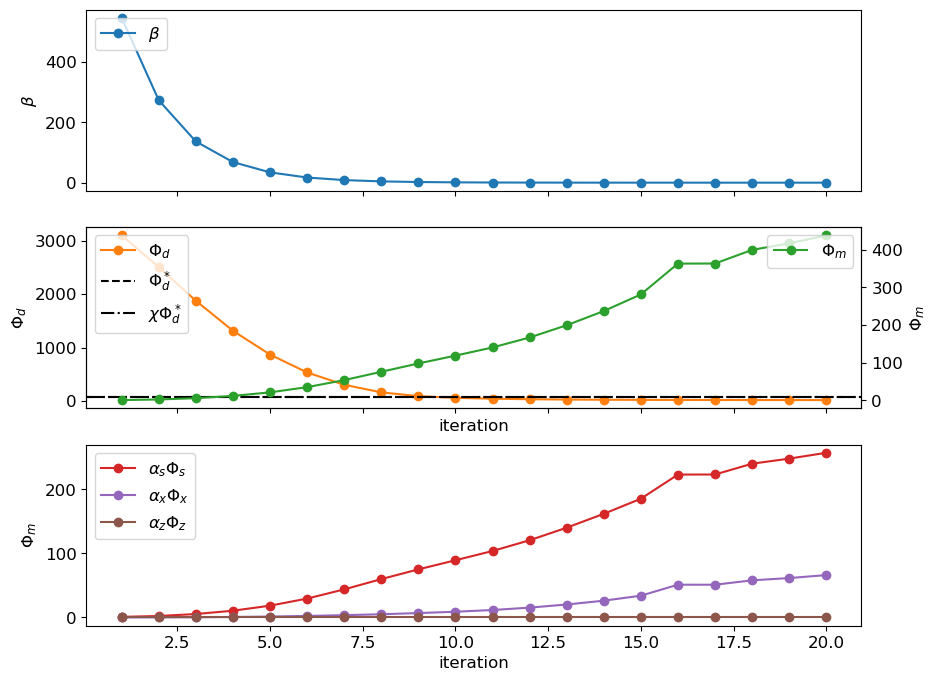

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

plot_beta(inversion_results, ax=ax[0])
plot_misfit_and_regularization(inversion_results, ax=ax[1])
plot_regularization_components(inversion_results, ax=ax[2])
ax[2].set_xlabel("iteration")

<Axes: xlabel='$\\Phi_m$', ylabel='$\\Phi_d$'>

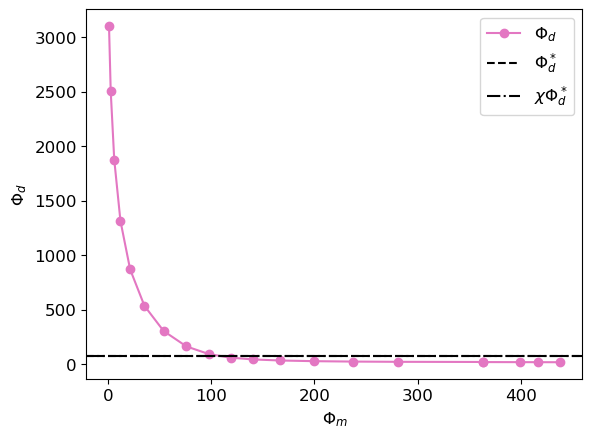

In [33]:
plot_tikhonov_curve(inversion_results)

### 6.3  recovered model

In [34]:
def plot_model(
    model=model_recovered, ax=None, clim=np.exp(np.r_[np.min(model_true), np.max(model_true)]), 
    colorbar=True, zlim=np.r_[-400, 0]
):
    """
    A plotting function for our recovered model 
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    out = mesh.plot_image(
        mapping * model, pcolor_opts={'norm':LogNorm(vmin=clim.min(),vmax=clim.max()), 'cmap':'Spectral'}, ax=ax,
    )

    ax.set_xlim(core_domain_x)
    ax.set_ylim(zlim)
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel('Easting (m)')
    ax.set_aspect(1.5)  # some vertical exxageration
    
    if colorbar is True:
        cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax, pad=0.25)
        cb.set_label("Resistivity ($\Omega$m)")
    
    return ax

### 6.4 Explore the results as a function of iteration

In [35]:
def plot_results_at_iteration(iteration=0):
    """
    A function to plot inversion results as a function of iteration 
    """
    fig = plt.figure(figsize=(12, 6))
    spec = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)

    ax_tikhonov = fig.add_subplot(spec[:, :2])
    ax_misfit = fig.add_subplot(spec[0, 2:])
    ax_model = fig.add_subplot(spec[1, 2:])

    plot_tikhonov_curve(inversion_results, ax=ax_tikhonov)
    ax_tikhonov.plot(
        inversion_results["phi_m"][iteration], inversion_results["phi_d"][iteration], 
        'ks', ms=10
    )
    ax_tikhonov.set_title(f"iteration {iteration}")
    
    plot_normalized_misfit(iteration=iteration, ax=ax_misfit)

    plot_model(inversion_results["model"][iteration], ax=ax_model, )
    # make the tikhonov plot square
    ax_tikhonov.set_aspect(1./ax_tikhonov.get_data_ratio())

    plt.tight_layout()

In [36]:
inversion_results_app = ipywidgets.interact(
    plot_results_at_iteration,
    iteration = ipywidgets.IntSlider(min=0, max=inversion_results["iteration"][-1]-1, value=0)
)
inversion_results_app

interactive(children=(IntSlider(value=0, description='iteration', max=19), Output()), _dom_classes=('widget-in…

<function __main__.plot_results_at_iteration(iteration=0)>

### 6.5 Compare with the True model 

<Axes: xlabel='Easting (m)', ylabel='Elevation (m)'>

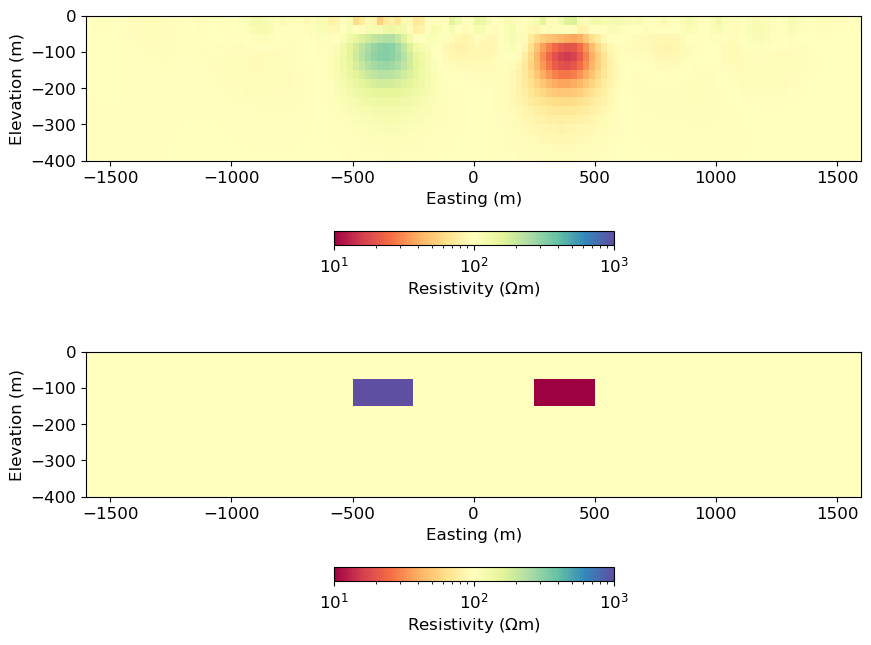

In [37]:
iteration = 9

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
clim = np.exp(np.r_[model_true.min(), model_true.max()])
plot_model(inversion_results["model"][iteration], clim=clim,  ax=ax[0])
plot_model(model_true, clim=clim,  ax=ax[1])

## Homework ✏️

What happens if you introduce a layer above the blocks? 
- Define a layer from z=-50 to z=-100. 
- Start with a resistive layer. 
    - How does this change our ability to resolve the blocks? 
- Now try with a conductive layer.
- Get creative! Build a model that interests you